In [176]:
import pandas as pd 
import numpy as np
import os 
import datetime
import matplotlib.pyplot as plt
import scipy.stats

a_billion = 10**9

# Step 1: Importing Data 

Our first task will be importing all of the high-fequency data for all 3 pairs from the website 


In [ ]:
t_BTC_USD_2021 = pd.read_table('/Users/zachmariani/Downloads/trades_narrow_BTC-USD_2021.delim')

# t_BTC_USD_2019 = pd.read_table('/Users/zachmariani/Downloads/trades_narrow_BTC-USD_2019.delim')

# t_BTC_USD_2018 = pd.read_table('/Users/zachmariani/Downloads/trades_narrow_BTC-USD_2018.delim')

In [4]:
#now let's take a look at then the trades 
print(len(t_BTC_USD))
t_BTC_USD.iloc[450:455].head()

3777963


,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
450,1618108297546968000,59055500000,3500000,1.0
451,1618108297546968000,59056580000,4743700,1.0
452,1618108297875268000,59069720000,792300,1.0
453,1618108299230676000,59073880000,2791630,1.0
454,1618108299230676000,59075500000,592590,1.0


In [3]:
#let's see when the start and end dates of this data are in a way that are easy to understnd

def format_my_nanos(nanos):
    dt = datetime.datetime.fromtimestamp(nanos / 1e9)
    return '{}{:03.0f}'.format(dt.strftime('%Y-%m-%d T %H:%M:%S.%f'), nanos % 1e3)

print('The data starts on: ', format_my_nanos(1618566402189875000))
print('The data ends on: ', format_my_nanos(1618786450622523000))


The data starts on:  2021-04-16 T 04:46:42.189875944
The data ends on:  2021-04-18 T 17:54:10.622523880


Now, once we've gotten a look at the data, we will construct our algorithm. We will have one large main function first, with a couple of helper functions to make it easier to understand for the reader. 

# Step 2: Designing Algorithm

In [47]:
'''
These are helper functions which help the algorithm find the closest indexes in order to more efficiently
sort and partition a given DataFrame. 
'''

def find_prior_neighbor(value, df, colname):
    #https://stackoverflow.com/questions/30112202/how-do-i-find-the-closest-values-in-a-pandas-series-to-an-input-number/53553226
    exactmatch = df[df[colname] == value]
    if not exactmatch.empty:
        return exactmatch.index[0]
    else:
        lowerneighbour_ind = df[df[colname] < value][colname].idxmax()
        return lowerneighbour_ind
    
def find_post_neighbour(value, df, colname):
    exactmatch = df[df[colname] == value]
    if not exactmatch.empty:
        return exactmatch.index[-1]
    else:
        upperneighbour_ind = df[df[colname] > value][colname].idxmin()
        return upperneighbour_ind


In [70]:
def VWAP(Q, tau_s, p, t_BTC_USD): 
    '''
    Q: target quantity, int sizebillionths
    tau_s: arrival time, in UTC nanoseconds
    p: participation rate, float [0,1] 
    
    t_BTC_USD: trade data, pd DF
    '''
    
    '''
    The first thing our algorithm will need to do is figure out what we think the volume 
    is going to look like. We will look at the previous n ticks of data to see what the 
    average volume is. NB: when first designing the algorithm, I thought it would be beneficial
    to make these decision based on the past several days and see the time/seasonal effects, 
    as was highlighted in the lecture video. However, the whole range of the data provided is 
    from 2021-04-16 until 2021-04-18 so this approach wasn't feasible. 
    '''
    
    #df_to_return is where we store information about each trade we end up making 

    df_to_return = pd.DataFrame(
                {
                'quantity_left_to_trade': Q,
                'quantity_traded': 'starting',
                'price': 'starting', 
                'time': tau_s, 
                'time_delta' : None
                }
                , index=[0])
    
    index_counter = 1
    
    #get the most recent time there is data for based on when we would like to start trading, tau_s
    most_recent_time = find_prior_neighbor(tau_s, t_BTC_USD, 'timestamp_utc_nanoseconds')
    
    #if we have at least 250 ticks beforehand, then we can just use these most recent ticks 
    if most_recent_time > 250: 
        past_df = t_BTC_USD.iloc[most_recent_time - 250: most_recent_time]

        t_0_int = int(past_df['timestamp_utc_nanoseconds'].iloc[0])
        t_1_int = int(past_df['timestamp_utc_nanoseconds'].iloc[-1])
        t_0 = np.datetime64(t_0_int, 'ns')
        t_1 = np.datetime64(t_1_int, 'ns')
        
        t_delta = t_1 - t_0
        t_delta = int(t_delta)

        avg_trade_size = past_df['SizeBillionths'].mean()
        
        #SizeBillionths per Nanosecond over the last 250 ticks 
        trade_size_over_time_window = avg_trade_size / t_delta 
    
    #else use all the previous data
    else:
        past_df = t_BTC_USD.iloc[:most_recent_time]
        
        t_0_int = int(past_df['timestamp_utc_nanoseconds'].iloc[0])
        t_1_int = int(past_df['timestamp_utc_nanoseconds'].iloc[-1])
        t_0 = np.datetime64(t_0_int, 'ns')
        t_1 = np.datetime64(t_1_int, 'ns')
        
        t_delta = t_1 - t_0
        t_delta = int(t_delta)

        avg_trade_size = past_df['SizeBillionths'].mean()
        
        #SizeBillionths per Nanosecond over all avaiable past data 
        trade_size_over_time_window = avg_trade_size / t_delta 
        

    #define our target participation in SizeBillionths per 0.1 seconds
    target_participation = p * trade_size_over_time_window * 100000000
        
    #figure out just how many blocks we'll need 
    blocks_to_trade = int(Q/target_participation)
    attempted_fill_quantity = target_participation
    left_to_trade = Q
    
    #0.1 seconds ahead
    target_time = tau_s + 100000000
    
    '''
    After we figure out what our size order should be in order to reach our target p, 
    we will then start counting blocks. Once the block reaches when we should place an order, 
    then we will place an order and restart our counter. This while loop contains the majority of 
    the bot's logic. It tells the bot to keep running until we've traded all of our size. 
    '''
    
    while blocks_to_trade > 0: 
        
        #if this is our last block, trade everything we have left 
        if blocks_to_trade == 1: 
            attempted_fill_quantity = Q - df_to_return.iloc[1:]['quantity_traded'].sum()
        
        time_to_trade_index = find_post_neighbour(target_time, t_BTC_USD, 'timestamp_utc_nanoseconds')
        time_to_trade = t_BTC_USD.iloc[time_to_trade_index]['timestamp_utc_nanoseconds']
        
        
        ################################## figure out the trade #####################################
        
        
        #look at the closest 500 trades to make it easier and quicker to work with 
        orders_to_reference = t_BTC_USD.iloc[time_to_trade_index : time_to_trade_index + 500]
        
        if Q > 0: 
            #if we're buying, then only look at trades which were buys 
            orders_to_reference = orders_to_reference[(orders_to_reference['Side'] > 0)]
            
        elif Q < 0:
            #if we're selling, then only look at trades which were sells 
            orders_to_reference = orders_to_reference[(orders_to_reference['Side'] < 0)]
        
        #then filter by the trades that were within 0.1 seconds of when we wanted to trade 
        orders_to_reference = \
            orders_to_reference[(orders_to_reference['timestamp_utc_nanoseconds'] < time_to_trade + 100000000)]
        
        #get the last order at this side and time, and then assume we participated here! 
        #this follows from the assignment's assumption of when we might have been able to participate 
        #NB: this is a very conservative approach
        fill_info = orders_to_reference
        
        if fill_info.empty: 
            #if we weren't successful, just move on and try again next round 
            #we wouldn't be successful if there were no trades at that time that we could have 
            #'participated' in... 
            fill_price = None 
            fill_quantity = None 
            fill_time = None 
            
        if not fill_info.empty: 
            #if we were successful! i.e. there were trades that meet that criteria that we could
            #have ended up participating in 
            
            blocks_to_trade = blocks_to_trade - 1
            fill_price = fill_info['PriceMillionths'].iloc[0]
            fill_quantity = int(attempted_fill_quantity)
            left_to_trade = left_to_trade - fill_quantity 
            fill_time = fill_info['timestamp_utc_nanoseconds'].iloc[0]
            
            time_delta = (fill_time - int(df_to_return.iloc[-1]['time'])) * 1e-9
        
            this_round = pd.DataFrame({
                'quantity_left_to_trade': left_to_trade,
                'quantity_traded' : fill_quantity,
                'price': fill_price, 
                'time_delta' : time_delta,
                'time': fill_time,
            }, index = [index_counter])
            
            index_counter = index_counter + 1
            
            df_to_return = df_to_return.append(this_round)
            
        time_delta = np.datetime64(int(time_to_trade), 'ns' ) - np.datetime64(int(target_time), 'ns') 
        time_delta = time_delta.astype('timedelta64[ms]').astype(float) / 1000
        
        #we then look for the next time interval we want to trade 
        target_time = time_to_trade + 100000000
        
        
    return df_to_return 
    #once we decide to place the trade, we need to figure out the actual price that it would execute at
    #and how far away we might expect to have been 

Now that we our algorithm working with the 2021 data, we will go through the 2018's and 2019's data and compare a couple of different metrics.

# Step 3: Analysis 

When running our analysis, we will pick a timestamp at the 25th, 50th, and 75th percentile from each dataset. We we then run each timestamp with different quantities 100000, 1000000 and then participation rates 0.01, 0.05, and 0.10. We will store all of this information in a dictionary where the keys are (year, timestamp, quantity, participation rate) and the values are the resulting dataframes from our algorithms.

NB: This was attempted with trade data from 2018, 2019, and 2021. Unfortunately, it seems that the file on Canvas titled trandes_narrow_BTC-USD_2019.delim.gz was only 123 bytes and the resulting DataFrame appears empty. As such, data from 2019 has been excluded from this analysis. See appendix for 2019 data. 

In [72]:
#first get all of the timestamps 
t_BTC_USD_2021 = pd.read_table('/Users/zachmariani/Downloads/trades_narrow_BTC-USD_2021.delim')

t_BTC_USD_2018 = pd.read_table('/Users/zachmariani/Downloads/trades_narrow_BTC-USD_2018.delim', sep='|')

data = [t_BTC_USD_2018, t_BTC_USD_2021]


In [73]:
#cycle through and get all the times
times = []
for df in data: 
    x25 = df['timestamp_utc_nanoseconds'].iloc[int(len(df) / 4)]
    x50 = df['timestamp_utc_nanoseconds'].iloc[int(len(df) / 2)]
    x75 = df['timestamp_utc_nanoseconds'].iloc[(int(len(df) / 4) * 3)]
    time = [x25, x50, x75]
    times.append(time)

#construct the dict map from (year, time, quantity, pariticpation_rate) -> df of algo performance 
dict_map = {}

years = [2018, 2021]
quantities = [100000, 1000000]
participation_rates = [0.01, 0.05, 0.10]
for n, year in enumerate(years): 
    time = times[n]
    for t in time: 
        for quantity in quantities: 
            for participation_rate in participation_rates: 
                key = (year, t, quantity, participation_rate)
                dict_map[key] = None

In [74]:
#THIS CELL IS VERY COMPUTATATIONALLY COSTLY 
for key, value in dict_map.items():
    
    t_BTC_USD_2021 = pd.read_table('/Users/zachmariani/Downloads/trades_narrow_BTC-USD_2021.delim')

    t_BTC_USD_2018 = pd.read_table('/Users/zachmariani/Downloads/trades_narrow_BTC-USD_2018.delim', sep='|')

    #the running print out makes sure that everything is working
    print('Running', key)
    if key[0] == 2018: 
        data = t_BTC_USD_2018
    if key[0] == 2021: 
        data = t_BTC_USD_2021
    tau_s = key[1]
    q = key[2]
    p = key[3]
    df_out = VWAP(Q = q, tau_s = tau_s, p = p, t_BTC_USD = data) 
    dict_map[key] = df_out


Running (2018, 1522656743835000000, 100000, 0.01)
Running (2018, 1522656743835000000, 100000, 0.05)
Running (2018, 1522656743835000000, 100000, 0.1)
Running (2018, 1522656743835000000, 1000000, 0.01)
Running (2018, 1522656743835000000, 1000000, 0.05)
Running (2018, 1522656743835000000, 1000000, 0.1)
Running (2018, 1522876993642000000, 100000, 0.01)
Running (2018, 1522876993642000000, 100000, 0.05)
Running (2018, 1522876993642000000, 100000, 0.1)
Running (2018, 1522876993642000000, 1000000, 0.01)
Running (2018, 1522876993642000000, 1000000, 0.05)
Running (2018, 1522876993642000000, 1000000, 0.1)
Running (2018, 1523126147216000000, 100000, 0.01)
Running (2018, 1523126147216000000, 100000, 0.05)
Running (2018, 1523126147216000000, 100000, 0.1)
Running (2018, 1523126147216000000, 1000000, 0.01)
Running (2018, 1523126147216000000, 1000000, 0.05)
Running (2018, 1523126147216000000, 1000000, 0.1)
Running (2021, 1618422573621057000, 100000, 0.01)
Running (2021, 1618422573621057000, 100000, 0.0

Now, we are interested in a couple of performance metrics, we'll use notional/time, trading costs as a proportion of notional, average price accumulated to arrival prices. We will store all of these in a DataFrame named performance.

In [110]:
performance = pd.DataFrame(columns = 
    ['year', 'tau_s', 'q', 'p', 'notional_over_time', 'trading_costs', 'avg_price_to_arrival_price'])

for key, value in dict_map.items():
    year, tau_s, q, p = key
    
    #to get notional_over_time we first count the number of blocks we traded, assumed they would've been
    #0.1 seconds each in a perfect world, and then see how long the full thing actually took
    
    total_time = value['time'].iloc[-1] - value['time'].iloc[0]
    number_of_trades = len(value)
    ideal_time = number_of_trades * 1e+8
    notional_over_time = total_time / ideal_time 
    
    #to get trading costs, we need to see the total amount traded times the cost traded times 50bps
    total_amount_traded = \
        (value['price'].iloc[1:] / 1000000) * (value['quantity_traded'].iloc[1:] / 1000000000)
    #divided price by million and price by billionths to get real $ terms 
    
    trading_costs = (total_amount_traded * 0.005).sum()
    
    arrival_price = value['price'].iloc[1]
    average_price = \
        (value['price'].iloc[1:] * value['quantity_traded'].iloc[1:]).sum() /\
                value['quantity_traded'].iloc[1:].sum()
    
    avg_price_to_arrival_price = average_price / arrival_price 
    
    dict_to_append = {
        'year': year, 
        'tau_s' : tau_s, 
        'q' : q,
        'p': p,
        'notional_over_time' : notional_over_time,
        'trading_costs' : trading_costs, 
        'avg_price_to_arrival_price' : avg_price_to_arrival_price
    }

    performance = performance.append(dict_to_append, ignore_index=True)

#take a look
performance.head()

,year,tau_s,q,p,notional_over_time,trading_costs,avg_price_to_arrival_price
0,2018.0,1.522657e+18,100000.0,0.01,123.872637,0.003479,0.999287
1,2018.0,1.522657e+18,100000.0,0.05,125.519189,0.003478,0.999274
2,2018.0,1.522657e+18,100000.0,0.10,134.640526,0.003482,1.000185
3,2018.0,1.522657e+18,1000000.0,0.01,95.037302,0.034698,0.996775
4,2018.0,1.522657e+18,1000000.0,0.05,87.909341,0.034871,1.001755


In [112]:
#now we can spilt between 2018 and 2021 
performance_18 = performance.loc[performance['year'] == 2018]
performance_21 = performance.loc[performance['year'] == 2021]

#and take a look at a couple of their metrics 

In [113]:
performance_18.describe()

,year,tau_s,q,p,notional_over_time,trading_costs,avg_price_to_arrival_price
count,18.0,1.800000e+01,18.000000,18.000000,18.000000,18.000000,18.000000
mean,2018.0,1.522887e+18,550000.000000,0.053333,93.263283,0.018953,1.001319
std,0.0,1.973134e+14,463046.179885,0.037885,30.091662,0.015967,0.004667
min,2018.0,1.522657e+18,100000.000000,0.010000,43.819375,0.003413,0.996775
25%,2018.0,1.522657e+18,100000.000000,0.010000,67.080071,0.003420,0.999277
50%,2018.0,1.522877e+18,550000.000000,0.050000,95.071177,0.018809,1.000177
75%,2018.0,1.523126e+18,1000000.000000,0.100000,123.719728,0.034303,1.001612
max,2018.0,1.523126e+18,1000000.000000,0.100000,134.640526,0.034871,1.018629


In [115]:
performance_21.describe()

,year,tau_s,q,p,notional_over_time,trading_costs,avg_price_to_arrival_price
count,18.0,1.800000e+01,18.000000,18.000000,18.000000,18.000000,18.000000
mean,2021.0,1.618607e+18,550000.000000,0.053333,3.978903,0.166150,1.000002
std,0.0,1.500897e+14,463046.179885,0.037885,0.745715,0.140528,0.000999
min,2021.0,1.618423e+18,100000.000000,0.010000,2.979075,0.027664,0.997683
25%,2021.0,1.618423e+18,100000.000000,0.010000,3.389625,0.030877,0.999862
50%,2021.0,1.618618e+18,550000.000000,0.050000,3.611061,0.154357,1.000044
75%,2021.0,1.618779e+18,1000000.000000,0.100000,4.668270,0.308812,1.000224
max,2021.0,1.618779e+18,1000000.000000,0.100000,5.215966,0.320732,1.002805


Now, let us discuss a couple of the notable results. 

First, **notional_over_time** changes drastically from 2018 to 2021. In 2018, the average notional_over_time was 93.2 while in 2021 it was 3.9. This tells us that it was much easier for our bots to trade in 2021 than in 2018. On average it would take 3.9x longer than an ideal situtation (ideal being defined as being able to trade one size block every 0.1 seconds). This makes sense, it would not be possible to trade a size block every single 0.1 second time interval. In 2018, it took nearly 93x as long as would be ideal. Given that the amount we were trying to trade was constant, this must be due to liquidity in the markets. It should be the case that smaller quanities were easier to trade through, so let's graph notional_over_time vs q:

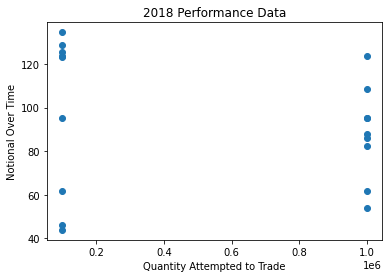

In [124]:
plt.scatter(performance_18['q'], performance_18['notional_over_time'])
plt.title('2018 Performance Data')
plt.xlabel('Quantity Attempted to Trade')
plt.ylabel('Notional Over Time');

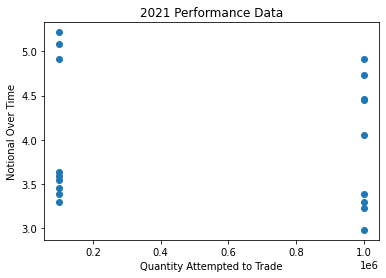

In [125]:
plt.scatter(performance_21['q'], performance_21['notional_over_time'])
plt.title('2021 Performance Data')
plt.xlabel('Quantity Attempted to Trade')
plt.ylabel('Notional Over Time');

From the graphs above, we see that as the amount we try to trade increases, the more difficult it is for our algorithm and the longer it takes. This makes sense. Further, we see that this trend holds against both datasets (2018 and 2021). 

Next, we discuss **trading costs**. We saw above that trading costs were substantially higher in 2021 than in 2018, we can attribute this to the fact that BitCoin prices were much higher in 2021 than they were in 2018 and because the trading costs are basis points and not a fixed amount, this makes sense. We can see the graph of the BitCoin ticks below.


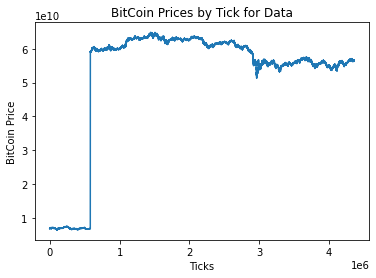

In [136]:
price = t_BTC_USD_2018['PriceMillionths']
price = price.append(t_BTC_USD_2021['PriceMillionths'])
price = price.values
plt.plot(price)
plt.title('BitCoin Prices by Tick for Data')
plt.ylabel('BitCoin Price')
plt.xlabel('Ticks');
#NB: Please excuse the gap and the lack of dates, the data before the jump is the 2018 data by ticks 
#the data after the jump is the 2021 data 

We will also look at histograms of trading costs between the two periods to see again how they compare. 

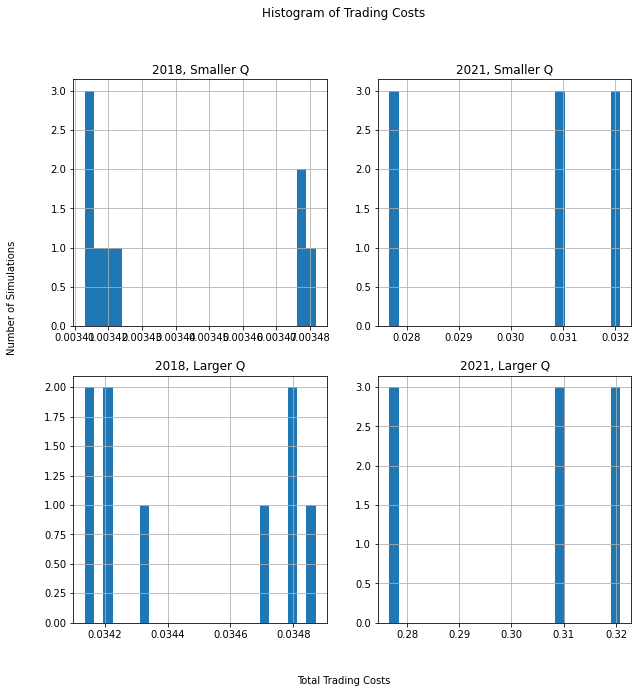

In [163]:
figure, axis = plt.subplots(2,2)
figure.set_figheight(10)
figure.set_figwidth(10)
plt.suptitle('Histogram of Trading Costs')
figure.text(0.5, 0.04, 'Total Trading Costs', ha='center')
figure.text(0.04, 0.5, 'Number of Simulations', ha = 'center', rotation = 'vertical')


performance_18.loc[performance['q'] == 100000]['trading_costs'].hist(bins = 25, ax = axis[0,0])\
.title.set_text('2018, Smaller Q')
performance_21.loc[performance['q'] == 100000]['trading_costs'].hist(bins = 25, ax = axis[0,1])\
.title.set_text('2021, Smaller Q')

performance_18.loc[performance['q'] == 1000000]['trading_costs'].hist(bins = 25, ax = axis[1,0])\
.title.set_text('2018, Larger Q')
performance_21.loc[performance['q'] == 1000000]['trading_costs'].hist(bins = 25, ax = axis[1,1])\
.title.set_text('2021, Larger Q');

We see very easy to intrepret and logical results. When we traded more, we had larger trading costs, when we traded at higher prices (ie in 2021 over 2018) we also had higher costs. 

Our final metric to discuss is **avg_price_to_arrival_price**. Our average was 1.001319 in 2018 and then 1.000002 in 2021. More importantly is the std of these metrics, in 2018 this was 0.004667 and in 2021 this was 0.000999. This implies that we do a great job of executing our orders at exactly where we want them to trade.

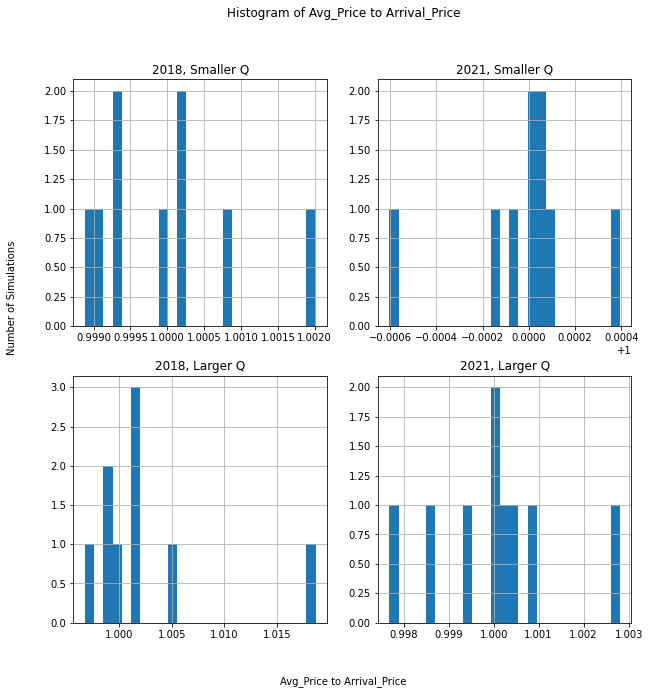

In [172]:
figure, axis = plt.subplots(2,2)
figure.set_figheight(10)
figure.set_figwidth(10)
plt.suptitle('Histogram of Avg_Price to Arrival_Price')
figure.text(0.5, 0.04, 'Avg_Price to Arrival_Price', ha='center')
figure.text(0.04, 0.5, 'Number of Simulations', ha = 'center', rotation = 'vertical')


performance_18.loc[performance['q'] == 100000]['avg_price_to_arrival_price'].hist(bins = 25, ax = axis[0,0])\
.title.set_text('2018, Smaller Q')
performance_21.loc[performance['q'] == 100000]['avg_price_to_arrival_price'].hist(bins = 25, ax = axis[0,1])\
.title.set_text('2021, Smaller Q')

performance_18.loc[performance['q'] == 1000000]['avg_price_to_arrival_price'].hist(bins = 25, ax = axis[1,0])\
.title.set_text('2018, Larger Q')
performance_21.loc[performance['q'] == 1000000]['avg_price_to_arrival_price'].hist(bins = 25, ax = axis[1,1])\
.title.set_text('2021, Larger Q');

list_of_avg_price_to_arrival_price = [performance_18.loc[performance['q'] == 100000]['avg_price_to_arrival_price'],\
                                     performance_21.loc[performance['q'] == 100000]['avg_price_to_arrival_price'], \
                                     performance_18.loc[performance['q'] == 1000000]['avg_price_to_arrival_price'], \
                                     performance_21.loc[performance['q'] == 1000000]['avg_price_to_arrival_price']]

In [178]:
print('The Skew and Kurtosis of 2018, Smaller Q', \
      scipy.stats.skew(list_of_avg_price_to_arrival_price[0]) , \
      scipy.stats.kurtosis(list_of_avg_price_to_arrival_price[0]))

print('The Skew and Kurtosis of 2021, Smaller Q', \
      scipy.stats.skew(list_of_avg_price_to_arrival_price[1]) , \
      scipy.stats.kurtosis(list_of_avg_price_to_arrival_price[1]))

print('The Skew and Kurtosis of 2018, Larger Q', \
      scipy.stats.skew(list_of_avg_price_to_arrival_price[2]) , \
      scipy.stats.kurtosis(list_of_avg_price_to_arrival_price[2]))

print('The Skew and Kurtosis of 2021, Larger Q', \
      scipy.stats.skew(list_of_avg_price_to_arrival_price[3]) , \
      scipy.stats.kurtosis(list_of_avg_price_to_arrival_price[3]))

The Skew and Kurtosis of 2018, Smaller Q 0.8917020978048465 -0.023924479612261074
The Skew and Kurtosis of 2021, Smaller Q -0.9032078801198576 1.1214723636268582
The Skew and Kurtosis of 2018, Larger Q 1.8911165278864546 2.5107064851105063
The Skew and Kurtosis of 2021, Larger Q 0.3104803445110952 0.14272237722540604


The Skew and Kurtosis information presented above gives us insights into our performance and the market dynamics as a whole. It makes sense that most of the time our skew is positive. The market for BitCoin over this period was often trending up so waiting longer to buy would imply that prices would be ever so slightly higher. Thus, the avg_price over arrival_price metric should be skewed a bit higher than 1. The Kurtosis information is a bit more difficult to intrepret and provide an economic intuition for. Kurtosis is for the most part positive which is a good sign for our algorithm. It implies that the distribution of our metric is rather tightly concentrated around the center. Given that our center is very close to 1.0, this implies we do a very good job of hitting our target prices. If the kurtosis were negative, it would imply that our distribution is not as spiked but rather a bit flatter which would tell us that more of our simulations were outside of the ideal 1.00 metric. 

Overall, we can conclude that (i) our VWAP algorithm performed its task quite nicely and was able to trade the entire size. In 2018, there were signficantly less volume in markets which made it so that it took much, much longer to trade than in 2021. 

# Appendix

In [69]:
#this is just to show that the 2019 data was in fact empty :(

t_BTC_USD_2019 = pd.read_table('/Users/zachmariani/Downloads/trades_narrow_BTC-USD_2019.delim', sep='|')
t_BTC_USD_2019.head()

,PriceMillionths,Side,SizeBillionths,received_utc_nanoseconds,timestamp_utc_nanoseconds


In [130]:
t_BTC_USD_2021

,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
0,1618108132515484000,59120710000,9701240,-1.0
1,1618108132515484000,59125070000,8122450,-3.0
2,1618108132989553000,59119950000,6563880,-1.0
3,1618108132989553000,59125070000,614120,-1.0
4,1618108133074765000,59119950000,16995890,-1.0
...,...,...,...,...
3777958,1618982230634907000,56702090000,28621900,1.0
3777959,1618982231452160000,56692990000,10004130,1.0
3777960,1618982231941238000,56695110000,3239980,-1.0
3777961,1618982232275265000,56700310000,158330,1.0
